In [1]:
import numpy as np
import random
import tqdm
import matplotlib.pyplot as plt
import pandas as pd


In [2]:
# 天气ID
weather_id_dict = {'沙暴':0,'高温':1,'晴朗':2}

# 天气消耗查询
weather_spend_num_dict = {2:np.array([5,7]),1:np.array([8,6]),0:np.array([10,10])}

# 动作ID
action_id_dict = {'行走':1,'停留':0,'挖矿':2}

# 动作消耗系数查询
action_spend_coef_dict = {1:2,0:1,2:3}

# 商品价格基数
item_price = np.array([5,10])

# 商品重量基数
item_weight = np.array([3,2])

In [3]:
# 天气查询
st = """高温	高温	晴朗	沙暴	晴朗	高温	沙暴	晴朗	高温	高温	
沙暴	高温	晴朗	高温	高温	高温	沙暴	沙暴	高温	高温	
晴朗	晴朗	高温	晴朗	沙暴	高温	晴朗	晴朗	高温	高温"""
weather_dict = {i:weather_id_dict.get(w.strip()) for i,w in enumerate(st.split('\t'))}

In [4]:
# 路径查询
map_dict = {1:[2,25],2:[1,3],3:[2,4,25],4:[3,5,24,25],5:[4,6,24],6:[5,7,23,24],7:[6,8,22],8:[7,9,22],9:[8,10,15,16,17,21,22],
      10:[9,11,13,15],11:[10,13,12],12:[11,13,14],13:[11,12,14,15,10],14:[12,13,15,16],15:[9,10,13,14,16],16:[14,15,9,17,18],
      17:[9,16,18,21],18:[16,17,19,20],19:[18,20],20:[19,18,21],21:[17,20,9,22,23,27],22:[7,8,9,23,21],23:[22,6,24,26,21],
      24:[4,5,6,23,25,26],25:[1,3,4,24,26],26:[25,24,23,27],27:[26,21],28:[10,13,12]}
path_dict = {k-1:[x-1 for x in map_dict.get(k)] for k in map_dict}

In [5]:
# state have two important key -- weather and position
def get_action(state,epsilon):
    weather = state['weather']
    position = state['position']
    action_list = [position]
    if position in [11,27]:
        action_list = [11,27] # 矿山可选择停留11或挖矿27
    if weather != 0:
        action_list += path_dict.get(position)
    if np.random.uniform() < epsilon: # epsilon-greedy
        return np.random.choice(action_list)
    else:
        # get the bigger Q-value
        return action_list[np.argmax(Q_matrix[weather,position,action_list])]

In [6]:
def get_Qvalue(state,action):
    weather = state['weather']
    position = state['position']
    return Q_matrix[weather,position,action]

In [7]:
def get_reward(state,action):
    weather = state['weather']
    position = state['position']
    if position == action:
        action_type = 0 #停留
    else:
        action_type = 1 #行走
    if action == 27:
        action_type = 2 #挖矿
        
    action_spend_coef = action_spend_coef_dict.get(action_type)
    weather_spend_num = weather_spend_num_dict.get(weather)
    
    extra_reward = 0
    if action == 27:
        extra_reward = 1000
    elif action == 26:
        extra_reward = 10000
    
    return extra_reward - action_spend_coef * (weather_spend_num * item_price).sum()

In [8]:
def get_max_new_Qvalue(new_state):
    weather = new_state['weather']
    position = new_state['position']
    action_list = [position]
    if weather != 0:
        action_list += path_dict.get(position)
    return max([get_Qvalue(new_state,new_action) for new_action in action_list])        

In [9]:
def agent(Q_matrix,lr,dr,epsilon):
    state = {'position':0}
    score = 0
    for i in range(30):
        if state['position'] == 26:
            # 到达终点
            Flag = True
            break
        elif i == 29 and state['position'] != 26:
            Flag = False
            # 未到终点
            break

        position = state['position']
        weather = weather_dict.get(i)
        state['weather'] = weather

        action = get_action(state,epsilon)
        Qvalue = get_Qvalue(state,action)
        reward = get_reward(state,action)
        new_state = {'weather':weather_dict.get(i+1), 'position':action}
        max_new_Qvalue = get_max_new_Qvalue(new_state)
        
        Q_matrix[weather,position,action] = Qvalue + lr * (reward + dr * max_new_Qvalue - Qvalue)
        
        state = new_state 
        score += reward
        
    return Q_matrix,score

In [10]:
def plot_scores(scores,rolling_window=100,figsize=(15,8)):
    '''分数展示'''
    f = plt.figure(figsize=figsize)
    plt.plot(scores, color='lightsteelblue')
    plt.title("Total_Profit")
    rolling_mean = pd.Series(scores).rolling(rolling_window).mean()
    plt.plot(rolling_mean, color='lightsalmon', lw=2.)
    #return rolling_mean

In [11]:
Q_matrix = np.zeros((3,28,28)) #27个位置+1个挖矿（计划：+1个村庄购物）
scores = []

lr = 0.1
dr = 0.9
n_episode = 10000
for i in tqdm.tqdm(range(n_episode)):
    epsilon = np.exp(-i/(n_episode/2))
    Q_matrix,score = agent(Q_matrix,lr,dr,epsilon)
    scores.append(score)

100%|██████████████████████████████████| 10000/10000 [00:00<00:00, 11651.70it/s]


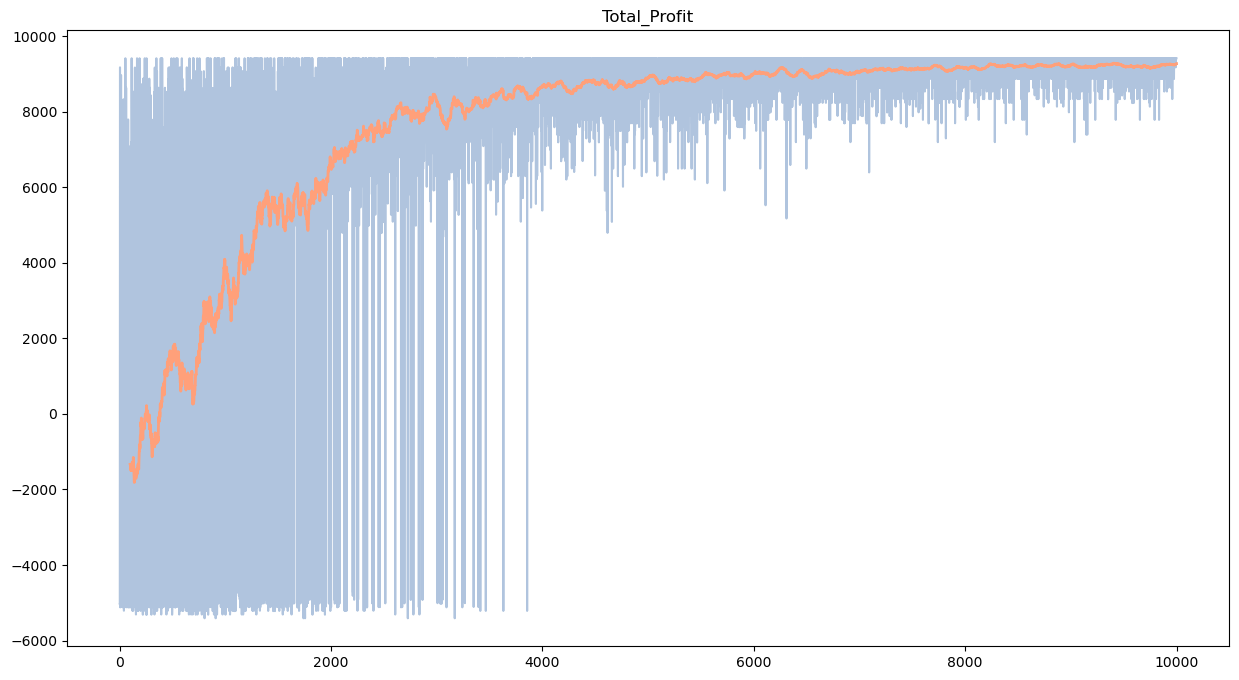

In [12]:
plot_scores(scores)